In [1]:
import torch

# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory. we'll be leveraging 100 MB of cleaned text from Wikipedia

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

(Sorry that i didn't automate this for you, I know I could have)

In [2]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [3]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [5]:
from collections import Counter
import random
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_en = set(stopwords.words('english'))
train_words = [wd for wd in words if wd not in stop_en]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leedt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import matplotlib.pyplot as plt
ctr = Counter(train_words)

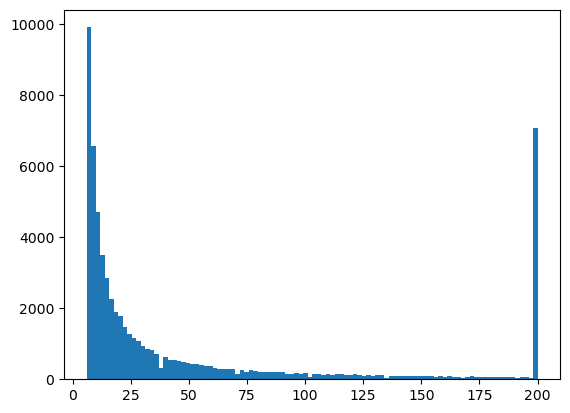

In [7]:
plt.hist([min(c, 200) for c in ctr.values()], bins=100)
plt.show()

In [8]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(train_words)
int_words = [vocab_to_int[word] for word in train_words]

if 0:
    # This filtering appears already done for us with min = 6
    word_counts = Counter(int_words)

    total_count = len(int_words)
    counts_raw = {word: count for word, count in word_counts.items()}
    int_words = [word for word in int_words if counts_raw[word] > 5]

word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

len(int_words), len(train_words), len(int_words)/len(train_words)


(10566033, 10566033, 1.0)

In [9]:
idx_to_id = {idx:id for idx, id in enumerate(int_words)}
train_length = len(int_words)
n_window = 3
n_vocab = len(vocab_to_int)

In [10]:
import torch
from torch import nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.center_emb = nn.Embedding(n_vocab, n_embed)
        self.outer_emb = nn.Embedding(n_vocab, n_embed)
#         self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x_center, x_outer, target):
        xc = self.center_emb(x_center)
        xo = self.outer_emb(x_outer)
        scores = torch.sum(xc * xo, axis=1)
        probs = torch.sigmoid(scores)
        
        return scores, probs
    
    def get_emb(self):
        return (self.outer_emb.weight + self.center_emb.weight).data.cpu().numpy()

In [11]:
n_neg = 8

In [12]:
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

In [13]:
wd_with_p = [wd for wd in freqs.keys()]
p_per_wd = [freqs[wd] ** (3/4) for wd in wd_with_p]
p_sum = sum(p_per_wd)
p_per_wd = [p/p_sum for p in p_per_wd]

In [14]:
pos_bs = 128
xi_center = np.random.choice(train_length - n_window * 2, pos_bs, replace=False) + n_window
xi_outer = (np.random.choice(n_window, pos_bs)+1) * np.random.choice([-1, 1], pos_bs) + xi_center

In [15]:
%timeit np.take(int_words, xi_center)

561 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


How much faster would it be if we vecttorized it with a dictionary instead?

In [16]:
id_getter = np.vectorize(idx_to_id.get)

In [17]:
%timeit id_getter(xi_center)

24.5 µs ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
xpos_center = id_getter(xi_center)
xpos_outer = id_getter(xi_outer)

xneg_center = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
xneg_outer = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)

In [19]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [20]:
import itertools
def cosine_similarity_vec(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cos = dot / np.dot(norm_u, norm_v)    
    return cos
def test_some_similarities(embed):
    breakpoint()
    word_pairs = [
                    ['father', 'mother'], ['boy', 'girl'], ['football', 'baseball'], ['good', 'bad'],
        ['accurate', 'precise'], ['allude','refer'],['anxious','eager'],['convince','persuade'],
        ['fewer','less'],['poisonous','venomous']
                ]
    
    v = {name: embed[vocab_to_int[name]] for name in list(itertools.chain(*word_pairs))}
    similarities = {w1 + '_' + w2: cosine_similarity_vec(v[w1], v[w2]) 
                    for w1, w2 in word_pairs}
    return similarities
#     print("cosine_similarity(france - paris, rome - italy) = ",
#           cosine_similarity_vec(v['france'] - v['paris'], v['italy'] - v['rome']))

In [46]:
PATH = 'skipgram'

In [47]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim= 64 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
# criterion = nn.NLLLoss(weight = torch.tensor([1/n_neg, 1.0])).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [48]:
print_every = 30
steps = 0
epochs = 5

for step in range(epochs * train_length):
    xi_center = np.random.choice(train_length - n_window * 2, pos_bs, replace=False) + n_window
    xi_outer = (np.random.choice(n_window, pos_bs)+1) * np.random.choice([-1, 1], pos_bs) + xi_center
    xneg_center = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
    xneg_outer = np.random.choice(wd_with_p, size = pos_bs * n_neg, replace=False, p = p_per_wd)
    x_center = np.concatenate((id_getter(xi_center), xneg_center))
    x_outer = np.concatenate((id_getter(xi_outer), xneg_outer))
    targets = np.array([1] * len(xi_center) + [0] * len(xneg_center))
    steps += 1
    x_center_torch, x_outer_torch, targets_torch = [torch.LongTensor(x).to(device) for x in [x_center, x_outer, targets]]
    
    logits, probs = model(x_center_torch, x_outer_torch, targets_torch)
    optimizer.zero_grad()
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        logits, targets_torch.float(), weight = targets_torch + 1 / n_neg)
#     loss = criterion(probs, targets_torch.float())
    loss.backward()
    optimizer.step()

    if step % print_every == 0:
        
        embed = model.get_emb()
        scores = test_some_similarities(embed)
        score_avg = np.mean([v for v in scores.values()])
        print(f'eval score: {score_avg:.5f}')
    if step % 10000 == 0 and step > 1:
        torch.save(model.state_dict(), PATH)
#         valid_examples, valid_similarities = cosine_similarity(model.get_emb(), device=device)
#         _, closest_idxs = valid_similarities.topk(6) # topk highest similarities

#         valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
#         for ii, valid_idx in enumerate(valid_examples):
#             closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
#             print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
#         print("...")

eval score: 0.38217
eval score: 0.38219
eval score: 0.38044
eval score: 0.38004
eval score: 0.37686
eval score: 0.37301
eval score: 0.37012


KeyboardInterrupt: 

In [43]:
torch.save(model.state_dict(), PATH)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [50]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.get_emb()

In [55]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

C:\Users\leedt\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\leedt\anaconda3\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


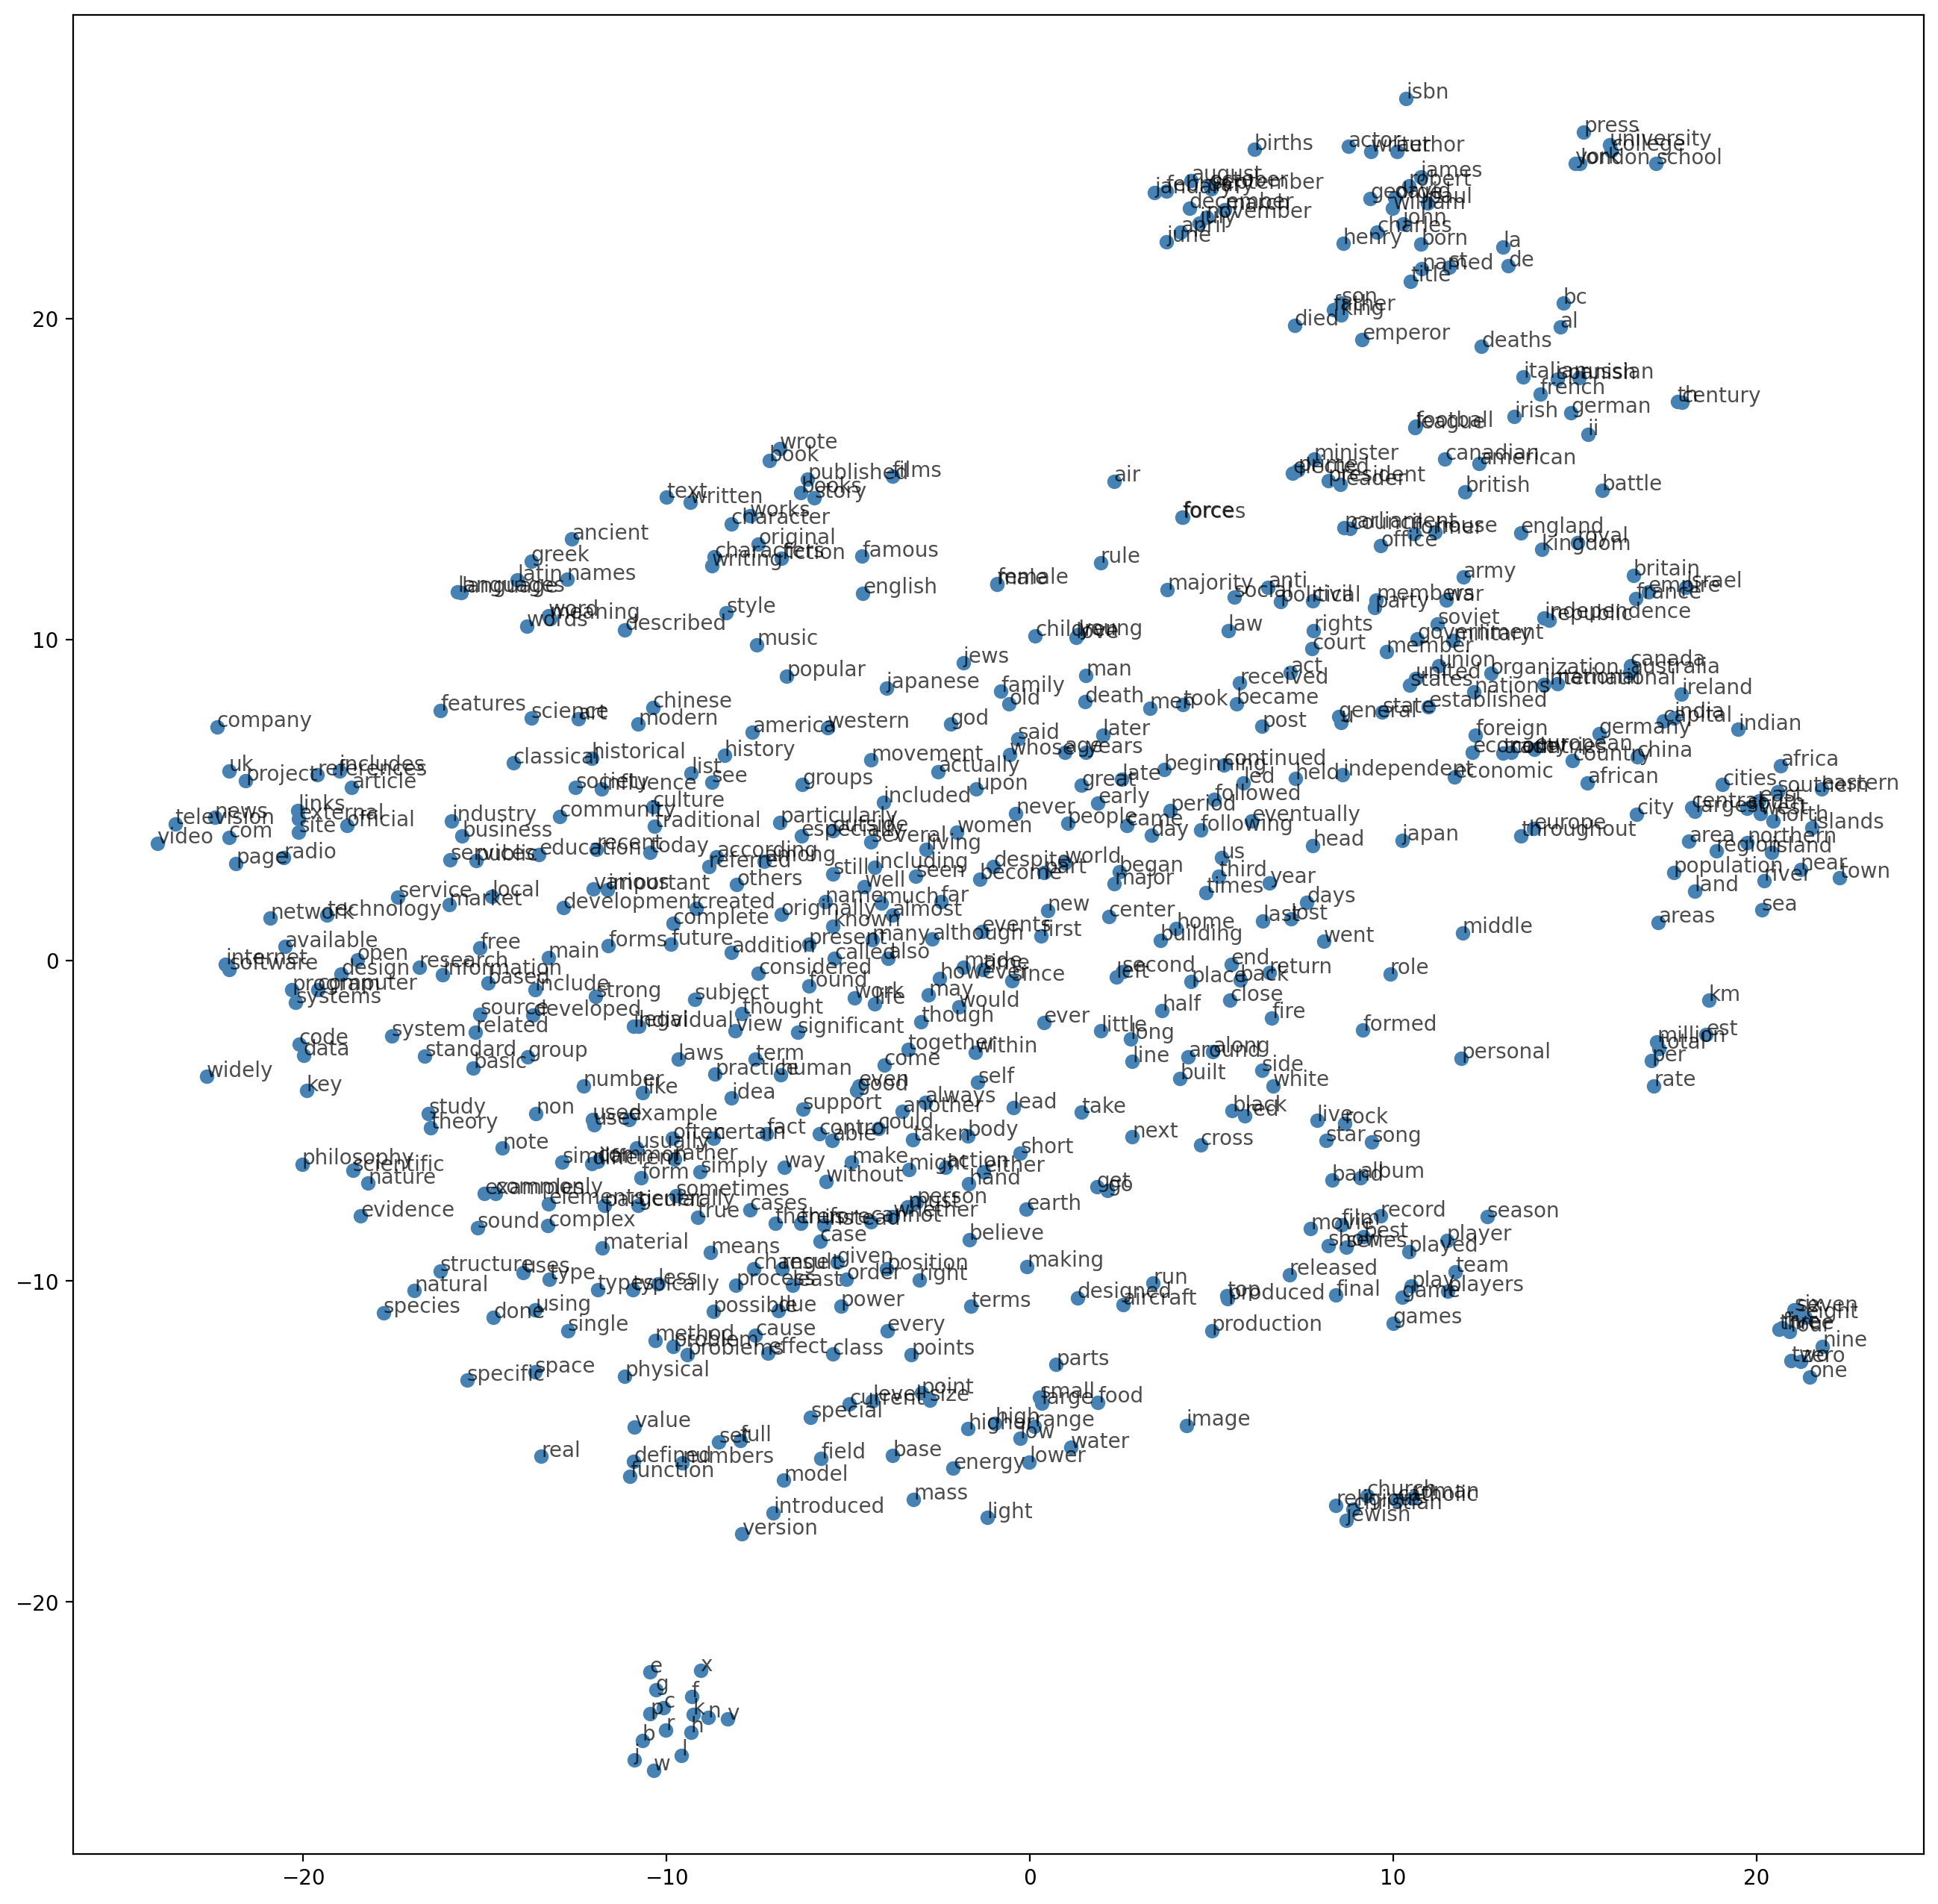

In [56]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [61]:
from sklearn.decomposition import PCA

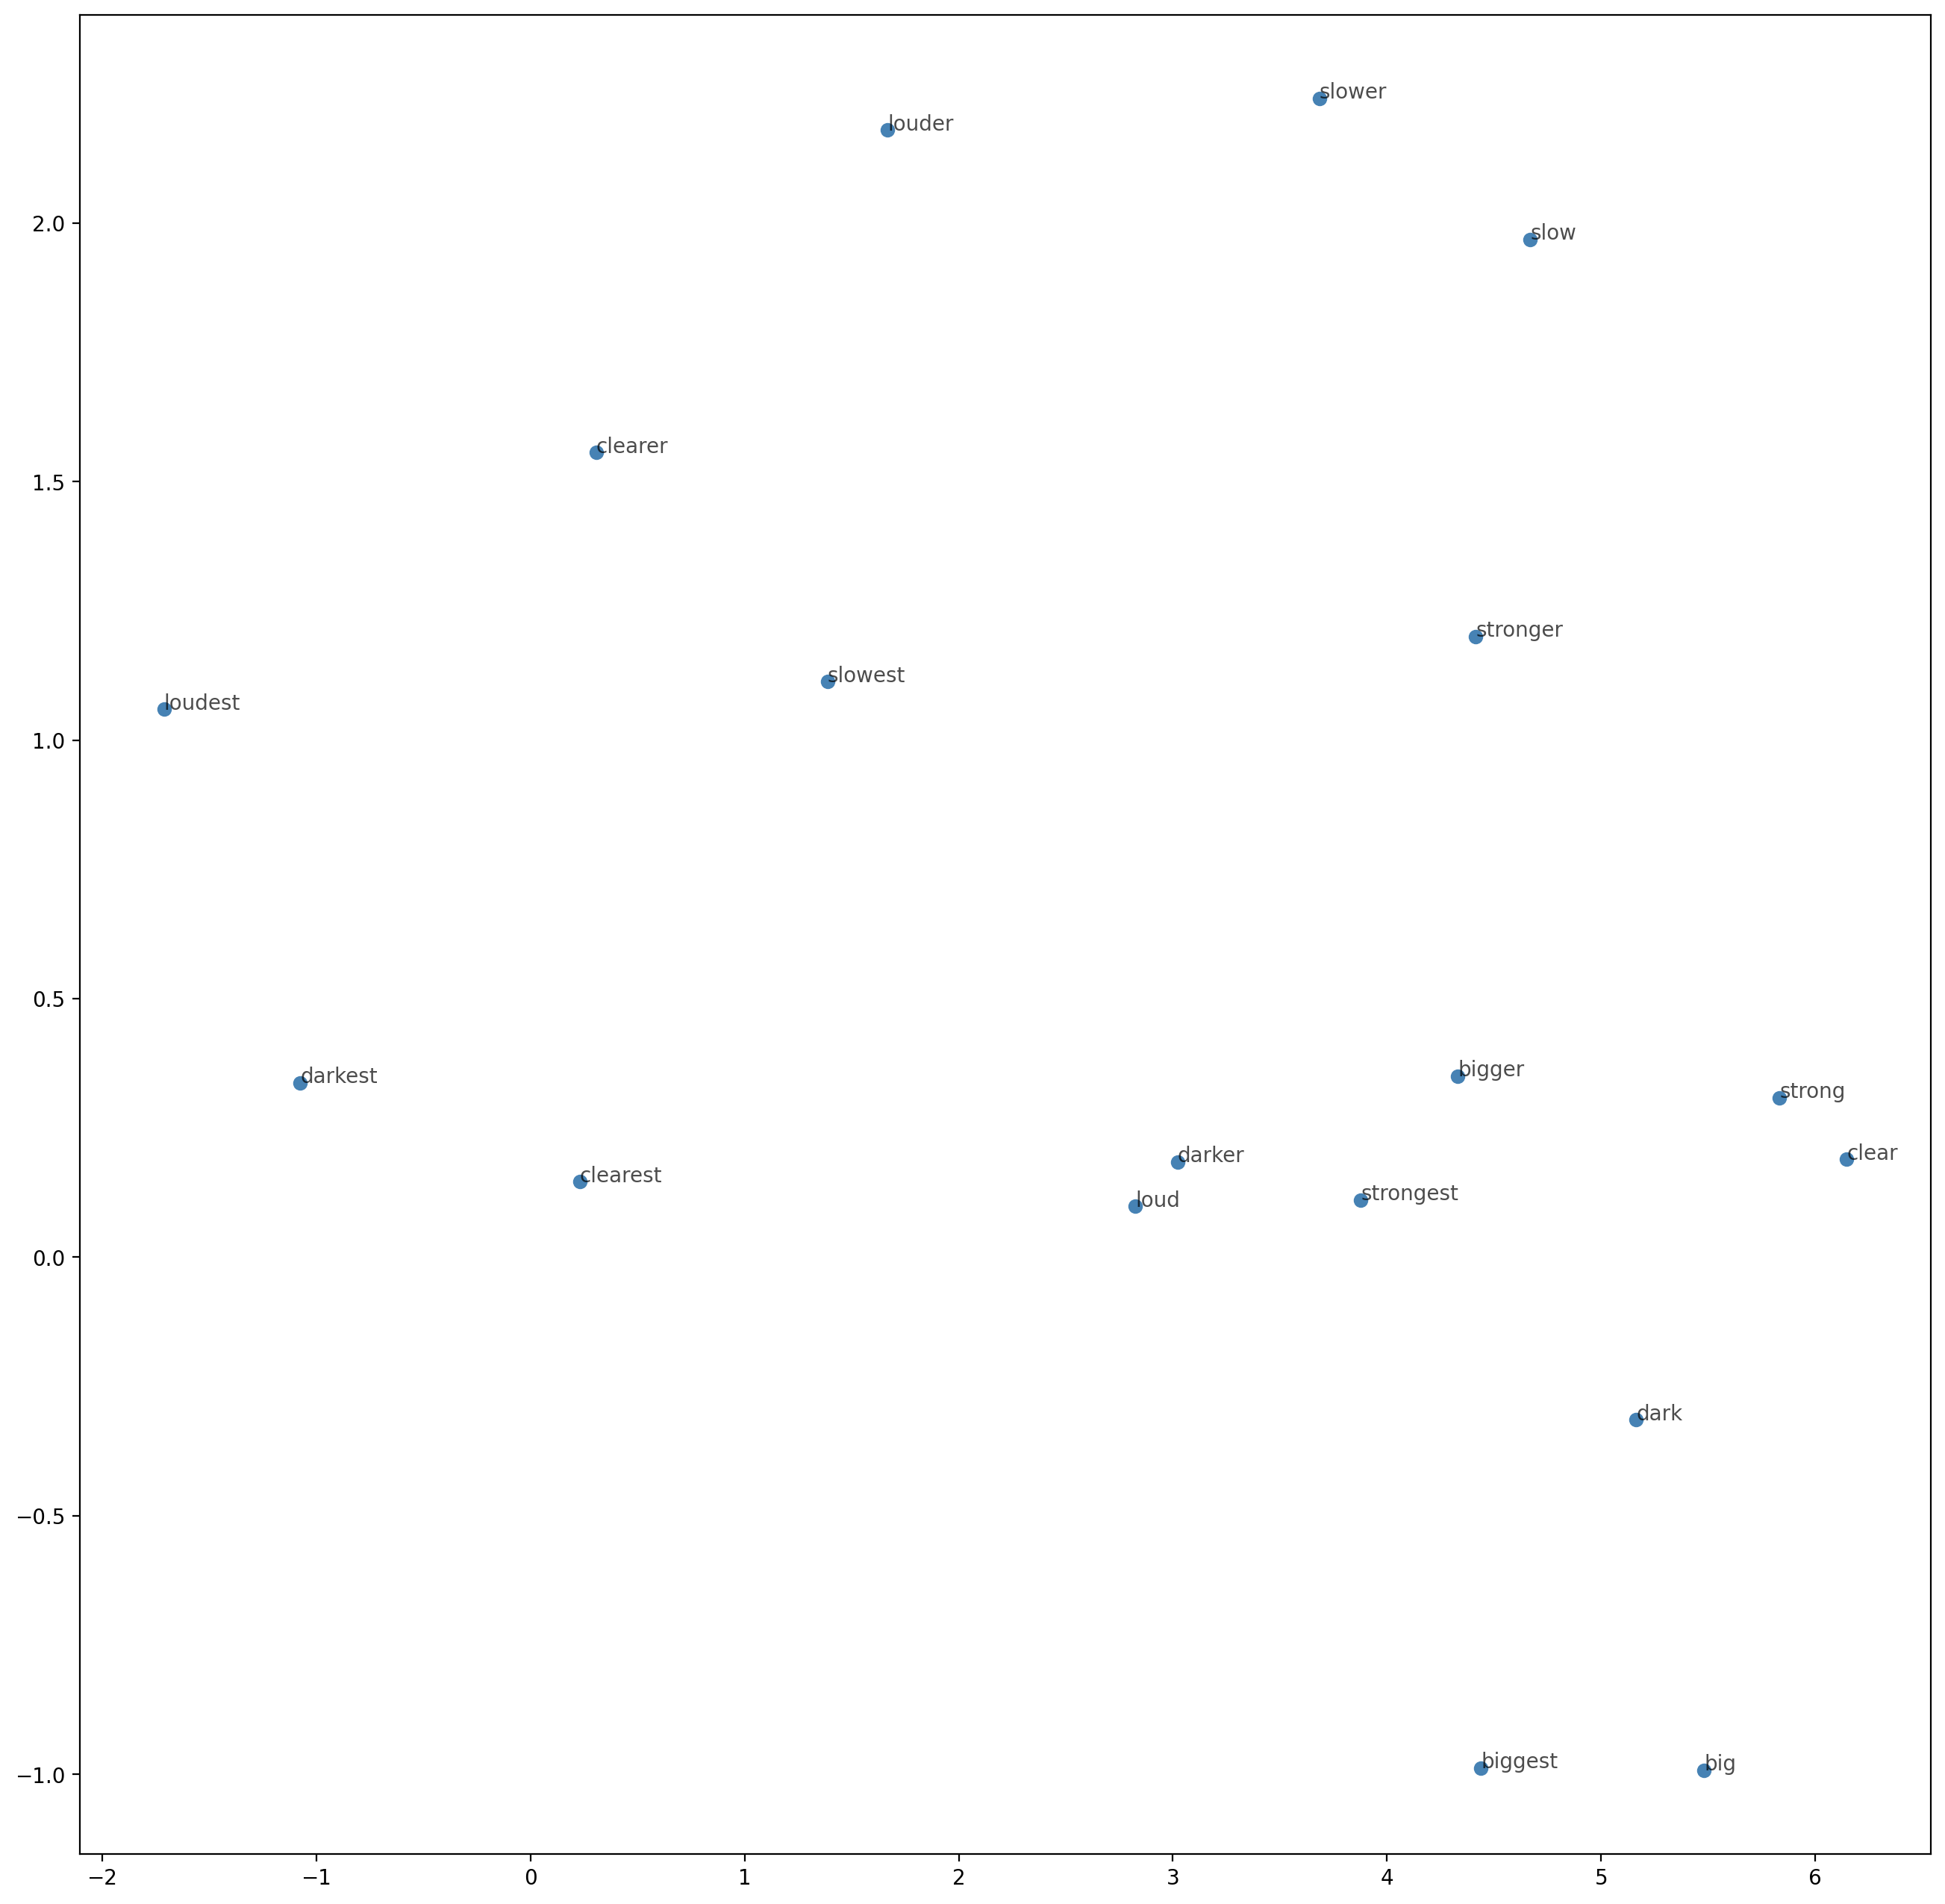

In [66]:
selected_words = ['big', 'bigger', 'biggest', 'strong', 'stronger', 'strongest', 'slow', 'slower', 'slowest',
                  'clear', 'clearer', 'clearest', 'loud', 'louder', 'loudest', 'dark', 'darker', 'darkest']
selected_idxes = [vocab_to_int[wd] for wd in selected_words]
lowdim_embeddings = PCA().fit_transform(embeddings)
embed_pca = lowdim_embeddings[selected_idxes, :2]
fig, ax = plt.subplots(figsize=(16, 16))
for i, idx in enumerate(selected_idxes):
    plt.scatter(*embed_pca[i, :], color='steelblue')
    plt.annotate(selected_words[i], (embed_pca[i, 0], embed_pca[i, 1]), alpha=0.7)